In [1]:
(ns google-sheets.psych-safety-generative-culture
  (:require [edmondson.google-forms :as forms]
            [edmondson.models.psychological-safety :as ps]
            [edmondson.models.generative-culture :as gc]
            [edmondson.reports :as reports]
            [edmondson.survey-analysis :as analysis]
            [edmondson.html :as html]
            [clojure.string :as str])
  (:use     [clojupyter.display :only (hiccup-html html render-mime)]))


;; Define the survey model used for this survey
;; This defines the "Constructs" (like "Psychological safety"
;; How the construct/each question is scored (e.g. 7-pt likert scale)

(def example-model
  (merge ps/psychological-safety
         gc/generative-culture
         {"Psychological safety domains"
          {:groups ["Which three topics would you find most uncomfortable to have a conversation about?"]
           :options ["Giving or receiving critical feedback" 
                     "Asking potentially risky/newbie questions"
                     "Disagreeing and voicing alternative opinions in team meetings or with specific people"
                     "Reevaluating our team processes and/or beliefs"
                     "Rebalancing the workload (delegating or asking for support)"
                     "Discussing career conversations and my future aspirations"
                     "Understanding promotions (or why one person was promoted over another)"
                     "Raising \"taboo\" topics (i.e. not up for discussion). You may specify the topic(s) under \"Other\"."]}
          ;; This allows us to group responses based on how people check
          ;; boxes in this question. Also makes it easier to count which
          ;; boxes get the most checks.

          "Open-ended feedback"
          ;; These are not analyzed quantitatively
          {:verbatims ["If you could change one behavior, one process, or just one thing about your team's work environment  -  what would you change and why?"
                       "What is one thing about your team that you really like and don't want to change, and why?"]}

          }))

;; Fetch and analyze survey results
(def survey-results
  (forms/configure-survey-results
   {:credentials "../../credentials.json"
    :token-directory "../../tokens"}
   example-model))


(hiccup-html [:h1 (:team-name survey-results) " readout report"])


Spidercats readout report

## Introduction
Using a short survey, we've measured the degree of psychological safety in the team. This document provides a short introduction to psychological safety, as well as an analysis of the survey data. 

This document shoulld be reviewed and edited by the survey manager to remove information that may identify individuals before being shared with the team.

## What is psychological safety?
**Psychological safety** is a belief that one will not be punished or humiliated for speaking up with ideas, questions, concerns or mistakes. Psychological safety is critical for creating inclusive and diverse work environments. When people fear that they will be blamed or judged they protect themselves; after all it is safer to be quiet than to speak up. When psychological safety is lacking we may hesitate to disagree with leadership, point out a problem, or pretend that errors did not happen.

[Research by Amy Edmondson](https://www.amazon.com/Fearless-Organization-Psychological-Workplace-Innovation/dp/1119477247) as well as “[Project Aristotle](https://rework.withgoogle.com/print/guides/5721312655835136/)”, a large study from Google, has shown that a high degree of psychological safety is an important aspect of effective teams.

Related to this is the concept of a **generative culture** which was popularized by the [Accelerate book](https://www.amazon.com/Accelerate-Software-Performing-Technology-Organizations/dp/1942788339) and The “[State of DevOps](https://www.devops-research.com/research.html)” research reports. This model considers culture as being on a spectrum ranging from “pathological” (power-oriented) to “bureaucratic” (rule-oriented) to “generative” (performance-oriented) cultures. In Accelerate it was shown that organizations with generative culture have higher levels of job satisfaction, as well as achieve higher levels of organizational performance (ability to deliver on the goals they set).


We’ve measured the degree of psychological safety and generative culture in the team using a set of valid and reliable survey questions taken from the research of Amy Edmondson (The Fearless Organization) and the [Accelerate book](https://www.amazon.com/Accelerate-Software-Performing-Technology-Organizations/dp/1942788339). The survey has two parts: one quantitative/[psychometric](https://en.wikipedia.org/wiki/Psychometrics) part measuring Psychological safety and generative culture; and two qualitative, open-ended topics "Psychological safety domains", "Open-ended feedback".

# Survey results

In [16]:
(let [time-now (java.time.ZonedDateTime/now)]
    (hiccup-html 
        [:p
         "The "
         (:team-name survey-results)
         " team was surveyed in "
         (str (.getMonth time-now)) ", " (str (.getYear time-now))
         " with the following participation rate:"]))



The Spidercats team was surveyed in AUGUST, 2022 with the following participation rate:

In [17]:
(printf "\nParticipation rate: %.1f%% (%d/%d respondents)"
        (* (:participation-rate survey-results) 100) 
        (:num-responses survey-results) 
        (:team-size survey-results))
;


Participation rate: 36.0% (9/25 respondents)

## Psychological safety scoring
This report provides a score for psychological safety for each individual (anonymous) survey respondent. We call this the Psychological Safety Index (PSI) and it is represented by a number between 0 and 100. Low PSI indicates low psychological safety, high PSI indicates high levels of psychological safety.

Psychological safety (PS) is scored using a "7pt Likert scale" with answers in the range “I strongly disagree – I strongly agree”. Each question is scored between 1 and 7, where 1 is the worst possible answer and 7 is the best possible answer. There are a total of 7 questions that are scored for PS, and these scores are summed up and normalized so each response is assigned a score between 0 and 100. A score over 78 is considered very good.

When evaluating psychological safety for a group of people, we look at the distribution of scores for each respondent.

## Average Psychological Safety Index

We want to dig in and look at the distribution of scores and outliers, however, we'll start by looking at the average PSI. 

In [18]:
(def psych-safety-results (get (:aggregate-results survey-results)
                               "Psychological safety"))
(def psi-stats
  (let [{:keys [mean quantile]} (get-in psych-safety-results [:construct-stats :psi])]
      {:p15 (nth quantile 1)
       :p50 (nth quantile 3)
       :p75 (nth quantile 4)
       :mean mean
       :measurement :psi}))

(hiccup-html 
    [:div
         [:p 
         "The average PSI is: "
             (reports/fmt-number (:mean psi-stats))
            ". "
             "PSI scores over "
             78
             " are considered very good. "     
            ]
         [:p "Here's a visualization of the 15th percentile (" (reports/fmt-number (:p15 psi-stats)) ")"
          " and the 75th percentile (" (reports/fmt-number (:p75 psi-stats)) ")"
          
          ]
     
         ])

        

The average PSI is: 24.7. PSI scores over 78 are considered very good. Here's a visualization of the 15th percentile (0.0) and the 75th percentile (33.0)

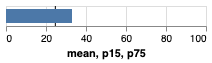

In [19]:

(render-mime "application/vnd.vegalite.v3+json" 
             {
                  :$schema "https://vega.github.io/schema/vega-lite/v5.json",              
                  :data {:values [psi-stats]}      
                  :layer [
                    {:mark {:type "rule"}
                     :encoding {
                        :x {:field :mean, :type "quantitative" :scale {:domain [0 100]}} :title nil}
                     }
                     {:mark {:type "bar", :size 14},
                      :encoding {
                        :x {:field :p15, :type "quantitative"},
                        :x2 {:field :p75},
                        :color {:field :measurement, :type "nominal" :legend nil}
                      }
                    }
                    
                    
               ]


    } )

## Question breakdown
Across all the responses, on average, the **worst scoring questions were**:

In [20]:
(hiccup-html (html/render-questions               
              (analysis/take-questions :worst-questions 4 psych-safety-results)
              (:model-index survey-results)))

"It is difficult to ask other members of this team for help." Mean score: 2.2 (stddev: 1.9). which is between "I agree/2" and "I agree a little bit/3". "No one on this team would deliberately act in a way that undermines my efforts." Mean score: 2.3 (stddev: 1.9). which is between "I disagree/2" and "I disagree a little bit/3". "If you make a mistake on this team, it is often held against you." Mean score: 2.4 (stddev: 1.8). which is between "I agree/2" and "I agree a little bit/3". "Members of this team are able to bring up problems and tough issues." Mean score: 2.4 (stddev: 1.8). which is between "I disagree/2" and "I disagree a little bit/3".

Across the responses, on average, the **best scoring questions were**:

In [21]:
(hiccup-html (html/render-questions               
              (analysis/take-questions :best-questions 4 psych-safety-results)
              (:model-index survey-results)))


"Working with members of this team, my unique skills and talents are valued and utilized." Mean score: 2.9 (stddev: 2.2). which is between "I disagree/2" and "I disagree a little bit/3". "People on this team sometimes reject others for being different." Mean score: 2.7 (stddev: 1.9). which is between "I agree/2" and "I agree a little bit/3". "It is safe to take a risk in this team." Mean score: 2.6 (stddev: 1.8). which is between "I disagree/2" and "I disagree a little bit/3". "Members of this team are able to bring up problems and tough issues." Mean score: 2.4 (stddev: 1.8). which is between "I disagree/2" and "I disagree a little bit/3".

## Outliers
When analyzing psychological safety, it is important to look at outliers as well as averages: It is important that *everyone* on the team feel psychologically safe - if that is not the case, we cannot consider the environment fully inclusive, nor can we expect it to bring out the best in everyone on the team.


### PSI-scores: the distribution
This is the distribution of PSI scores:

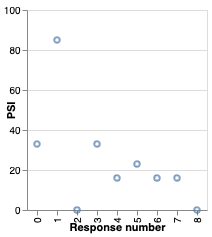

In [22]:
(render-mime "application/vnd.vegalite.v3+json" 
             {
                  :$schema "https://vega.github.io/schema/vega-lite/v4.json",
                  :description "Distribution of psych safety scores"
                  :data {:values (map-indexed (fn [i x] (assoc x :index i)) 
                                  (->>     
                                    (get-in psych-safety-results [:response-stats :response-scores])
                                    (map :measures)
                                    (filter #(not (Double/isNaN (:avg %))))))}
                  :mark "point"
                  :encoding {
                    :y {:field :psi :type "quantitative" :scale {:domain [0 100]} :title "PSI"}
                    :x {:field :index :type "ordinal" :title "Response number"}
                  }
                })


As we can see, there are a people on the team who perceive the environment as less psychologically safe than others. The worsts scores are:

In [23]:
(->> (get-in psych-safety-results [:response-stats :worst-scores])
     (take 10)
     (map #(get-in % [:measures :psi])))

(0 0 16 16 16 23 33 33 85)

### Question breakdown for outliers
Let's do a breakdown of scores by question for this group scoring lowest on PSI.



In [24]:
(def worst-15th-percentile-responses 
        (analysis/filter-responses ["Psychological safety" :psi] 
                                 #(<= % (:p15 psi-stats)) 
                                 (:scored-responses survey-results)))

(hiccup-html 
    [:div
         [:p "There are " (count worst-15th-percentile-responses) " responses"
          " which are scored lower than the 15th percentile score (" (reports/fmt-number (:p15 psi-stats)) ")."          
          ]])

        

There are 2 responses which are scored lower than the 15th percentile score (0.0).

Across the 15th percentile of worst-scoring responses, the **worst scoring questions were**:

In [25]:
(def worst-outlier-psych-safety-results 
    (get (analysis/aggregate-scores example-model worst-15th-percentile-responses)
         "Psychological safety"))


(hiccup-html (html/render-questions               
              (analysis/take-questions :worst-questions 4 worst-outlier-psych-safety-results)
              (:model-index survey-results)))


"If you make a mistake on this team, it is often held against you." Mean score: 1.0 (stddev: 0.0). which is between "I strongly agree/1" and "I strongly agree/1". "Members of this team are able to bring up problems and tough issues." Mean score: 1.0 (stddev: 0.0). which is between "I strongly disagree/1" and "I strongly disagree/1". "People on this team sometimes reject others for being different." Mean score: 1.0 (stddev: 0.0). which is between "I strongly agree/1" and "I strongly agree/1". "It is safe to take a risk in this team." Mean score: 1.0 (stddev: 0.0). which is between "I strongly disagree/1" and "I strongly disagree/1".

Across the worst-scoring responses, the **best scoring questions were**:

In [26]:
(hiccup-html (html/render-questions               
              (analysis/take-questions :best-questions 3 worst-outlier-psych-safety-results)
              (:model-index survey-results)))


"Working with members of this team, my unique skills and talents are valued and utilized." Mean score: 1.0 (stddev: 0.0). which is between "I strongly disagree/1" and "I strongly disagree/1". "No one on this team would deliberately act in a way that undermines my efforts." Mean score: 1.0 (stddev: 0.0). which is between "I strongly disagree/1" and "I strongly disagree/1". "It is difficult to ask other members of this team for help." Mean score: 1.0 (stddev: 0.0). which is between "I strongly agree/1" and "I strongly agree/1".

## Generative culture scoring
This report provides a score for generative culture for each individual (anonymous) survey respondent. We call this the Generative Culture Index (GCI) and it is represented by a number between 0 and 100. Low GCI indicates a pathological culture, and high GCI indicates a more generative culture.

Generative culture (GC) is scored using a "7pt Likert scale" with answers in the range “I strongly disagree – I strongly agree”. Each question is scored between 1 and 7, where 1 is the worst possible answer and 7 is the best possible answer. There are a total of 6 questions that are scored for GC, and these scores are summed up and normalized so each response is assigned a score between 0 and 100. 

## Average Generative Culture Index

We want to dig in and look at the distribution of scores and outliers, however, we'll start by looking at the average PSI. 

In [27]:
(def gen-culture-results (get (:aggregate-results survey-results)
                               "Generative culture"))
(def gci-stats
  (let [{:keys [mean quantile]} (get-in gen-culture-results [:construct-stats :gci])]
      {:p15 (nth quantile 1)
       :p50 (nth quantile 3)
       :p75 (nth quantile 4)
       :mean mean
       :measurement :gci}))


(hiccup-html 
    [:div
         [:p 
         "The average GCI is: "
             (reports/fmt-number (:mean gci-stats))
            ". "
             "GCI scores over "
             78
             " are considered very good. "     
            ]
         [:p "Here's a visualization of the 15th percentile (" (reports/fmt-number (:p15 gci-stats)) ")"
          " and the 75th percentile (" (reports/fmt-number (:p75 gci-stats)) ")"
          
          ]
     
         ])

        

The average GCI is: 37.7. GCI scores over 78 are considered very good. Here's a visualization of the 15th percentile (0.0) and the 75th percentile (69.0)

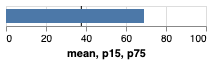

In [28]:

(render-mime "application/vnd.vegalite.v3+json" 
             {
                  :$schema "https://vega.github.io/schema/vega-lite/v5.json",              
                  :data {:values [gci-stats]}      
                  :layer [
                    {:mark {:type "rule"}
                     :encoding {
                        :x {:field :mean, :type "quantitative" :scale {:domain [0 100]}} :title nil}
                     }
                     {:mark {:type "bar", :size 14},
                      :encoding {
                        :x {:field :p15, :type "quantitative"},
                        :x2 {:field :p75},
                        :color {:field :measurement, :type "nominal" :legend nil}
                      }
                    }
                    
                    
               ]


    } )

## Question breakdown
Across all the responses, on average, the **worst scoring questions were**:

In [29]:
(hiccup-html (html/render-questions               
              (analysis/take-questions :worst-questions 4 gen-culture-results)
              (:model-index survey-results)))

"Responsibilities are shared." Mean score: 2.8 (stddev: 2.0). which is between "I disagree/2" and "I disagree a little bit/3". "Cross-functional collaboration is encouraged and rewarded." Mean score: 3.1 (stddev: 2.3). which is between "I disagree a little bit/3" and "I neither agree or disagree/4". "Failures are treated primarily as opportunities to improve." Mean score: 3.1 (stddev: 2.3). which is between "I disagree a little bit/3" and "I neither agree or disagree/4". "New ideas are welcomed." Mean score: 3.3 (stddev: 2.3). which is between "I disagree a little bit/3" and "I neither agree or disagree/4".

Across the responses, on average, the **best scoring questions were**:

In [30]:
(hiccup-html (html/render-questions               
              (analysis/take-questions :best-questions 3 gen-culture-results)
              (:model-index survey-results)))

"Messengers are not punished when they deliver news of failures or other bad news." Mean score: 3.7 (stddev: 2.5). which is between "I disagree a little bit/3" and "I neither agree or disagree/4". "Information is actively sought." Mean score: 3.6 (stddev: 2.5). which is between "I disagree a little bit/3" and "I neither agree or disagree/4". "Failures are investigated, not ignored or hidden." Mean score: 3.4 (stddev: 2.3). which is between "I disagree a little bit/3" and "I neither agree or disagree/4".

## Outliers

When analyzing generative culture, it is important to look at outliers as well as averages.

### GCI-scores: the distribution

This is the distribution of GCI scores:

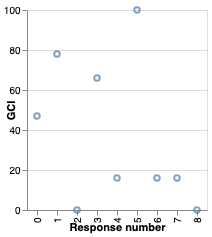

In [31]:
(render-mime "application/vnd.vegalite.v3+json" 
             {
                  :$schema "https://vega.github.io/schema/vega-lite/v4.json",
                  :description "Distribution of generative culture scores"
                  :data {:values (map-indexed (fn [i x] (assoc x :index i)) 
                                  (->>     
                                    (get-in gen-culture-results [:response-stats :response-scores])
                                    (map :measures)
                                    (filter #(not (Double/isNaN (:avg %))))))}
                  :mark "point"
                  :encoding {
                    :y {:field :gci :type "quantitative" :scale {:domain [0 100]} :title "GCI"}
                    :x {:field :index :type "ordinal" :title "Response number"}
                  }
                })

As we can see, there are a people on the team who perceive the culture differently than others. The worsts scores are:

In [32]:
(->> (get-in gen-culture-results [:response-stats :worst-scores])
     (take 10)
     (map #(:gci (:measures %))))

(0 0 16 16 16 47 66 78 100)

### Question breakdown for outliers

Let's do a breakdown of scores by question for this group scoring lowest on GCI.



In [33]:
(def worst-15th-percentile-responses 
        (analysis/filter-responses ["Generative culture" :gci]
                                 #(<= % (:p15 gci-stats))
                                 (:scored-responses survey-results)))

(hiccup-html
    [:div
         [:p "There are " (count worst-15th-percentile-responses) " responses"
          " which are scored lower than the 15th percentile score (" (reports/fmt-number (:p15 gci-stats)) ")."          
          ]])

        

There are 2 responses which are scored lower than the 15th percentile score (0.0).

Across the 15th percentile of worst-scoring responses, the **worst scoring questions were**:

In [34]:
(def worst-outlier-gen-culture-results 
    (get (analysis/aggregate-scores example-model worst-15th-percentile-responses)
         "Generative culture"))


(hiccup-html (html/render-questions               
              (analysis/take-questions :worst-questions 4 worst-outlier-gen-culture-results)
              (:model-index survey-results)))


"Messengers are not punished when they deliver news of failures or other bad news." Mean score: 1.0 (stddev: 0.0). which is between "I strongly disagree/1" and "I strongly disagree/1". "Responsibilities are shared." Mean score: 1.0 (stddev: 0.0). which is between "I strongly disagree/1" and "I strongly disagree/1". "Cross-functional collaboration is encouraged and rewarded." Mean score: 1.0 (stddev: 0.0). which is between "I strongly disagree/1" and "I strongly disagree/1". "New ideas are welcomed." Mean score: 1.0 (stddev: 0.0). which is between "I strongly disagree/1" and "I strongly disagree/1".

Across the 15th percentile of worst-scoring responses, the **best scoring questions were**:

In [35]:
(hiccup-html (html/render-questions               
              (analysis/take-questions :best-questions 3 worst-outlier-gen-culture-results)
              (:model-index survey-results)))


"Information is actively sought." Mean score: 1.0 (stddev: 0.0). which is between "I strongly disagree/1" and "I strongly disagree/1". "Failures are treated primarily as opportunities to improve." Mean score: 1.0 (stddev: 0.0). which is between "I strongly disagree/1" and "I strongly disagree/1". "Failures are investigated, not ignored or hidden." Mean score: 1.0 (stddev: 0.0). which is between "I strongly disagree/1" and "I strongly disagree/1".

# Psychological safety - domains
The degree of psychological safety in a situation can depend on the topic being discussed. It is possible that some topics are perceived as safe whereas others are considered unsafe. To better understand team sentiment, we asked each respondent "Which three topics would you find most uncomfortable to have a conversation about?"

The participants picked among the following options:

In [36]:
(def domain-options (get-in example-model ["Psychological safety domains" :options]))

(def domains-question "Which three topics would you find most uncomfortable to have a conversation about?")

(defn parse-domains [answer]
    (->> domain-options
         (map (fn [a]                   
                  [a (.indexOf answer a)])) ;; find index of each possible answer
         (filter (fn [[_ index]] (>= index 0)))))

(defn answer-frequencies 
    [answer]
    (let [domain-answers (parse-domains answer)
          unparsed-answer 
              (reduce 
               (fn [acc [a index]] 
                   (-> acc
                       (clojure.string/replace a "") ;; remove parsed answers
                       (clojure.string/replace #"^(, )+" "") ;; clean up string by removing leading ", "
                       clojure.string/trim))
                answer
                domain-answers)
          domain-answers (map first domain-answers) ;; remove indexes
          parsed-answers (if-not (clojure.string/blank? unparsed-answer)
                                (conj domain-answers unparsed-answer)
                                domain-answers)]
        (zipmap parsed-answers (repeat 1))))

(def domains-answers-counts 
    (->> (:scored-responses survey-results) ;; all responses
        (map #(get-in % [:groups domains-question])) ;; get the responses to the domain-question
        (remove clojure.string/blank?)
        (map answer-frequencies);; [{:a 1 :b 1 :c 1} {:a 1 :b 1 :d 1} {:d 1 :e 1 :f 1}]
        (apply (partial merge-with +));; {:a 2 :b 2 :c 1 :d 1 :e 1 :f 1}
        (sort-by second) ;; ([:f 1] [:e 1] [:d 1] [:c 1] [:b 2] [:a 2])
        reverse))

(hiccup-html 
    [:ul (map (fn [[key count]]
                  [:li key ": " count " votes."]
                  )
              domains-answers-counts)])

Giving or receiving critical feedback: 6 votes. Disagreeing or voicing alternative opinions in team meetings, Understanding what it takes to get promoted (or why one person was promoted over another): 3 votes. Rebalancing the workload (delegating or asking for support): 1 votes. Reevaluating our team processes and/or beliefs: 1 votes. Disagreeing and voicing alternative opinions in team meetings or with specific people: 1 votes. Disagreeing or voicing alternative opinions in team meetings, Rebalancing your workload (delegating or asking for support): 1 votes. Asking potentially dumb/newbie questions, Disagreeing or voicing alternative opinions in team meetings: 1 votes. Disagreeing with specific people ("oh, no one argues with them"): 1 votes.


# Open-ended feedback
We also asked more open-ended questions, allowing people to provide verbatim responses. In these questions, we asked “If you could change one team process or one thing about how the team works, what would you change and why?” and “What is something the team does really well? Something that would make you very disappointed if the team stopped doing or something that makes you proud to be part of the team.”


### Q: "If you could change one behavior, one process, or just one thing about your team's work environment  -  what would you change and why?"
Answers:

In [37]:
(def open-ended-verbatims (:verbatims (get (:aggregate-results survey-results) "Open-ended feedback")))

(def could-be-improved 
    (->> 
        (get open-ended-verbatims "If you could change one behavior, one process, or just one thing about your team's work environment  -  what would you change and why?")
        (filter (complement clojure.string/blank?))))

(hiccup-html 
    [:ul (map #(do [:li "\"" % "\""]) could-be-improved)])

"A" "1" "X" "P" "Psy low" "P" "P"

### Q: "What is one thing about your team that you really like and don't want to change, and why?"
Answers:

In [38]:
(def working-well 
 (->> (get open-ended-verbatims "What is one thing about your team that you really like and don't want to change, and why?")
    (filter (complement clojure.string/blank?))))

(hiccup-html 
    [:ul (map #(do [:li "\"" % "\""]) working-well)])



"B" "2" "Y" "Q" "Gen high" "Q" "Q"

# Have feedback?
Please send to @krukow / krukow@github.com